In [178]:
# !pip3 install category_encoders
# !pip3 install scikit-learn
# !pip3 install shap

# Libraries

In [ ]:
import glob
import math
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from pprint import pprint

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data

In [180]:
file_paths = glob.glob('Kaggle_HDB/*.csv')

df = []
for file in file_paths:
    print(file)
    df_temp = pd.read_csv(file, parse_dates=['month'])
    df.append(df_temp)

# 3. Concatenate all DataFrames into one
df_combined = pd.concat(df, ignore_index=True).reset_index(drop=True)
df_combined = df_combined.sort_values(by='month')
df_combined

Kaggle_HDB\resale-flat-prices-based-on-approval-date-1990-1999.csv
Kaggle_HDB\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv
Kaggle_HDB\resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv
Kaggle_HDB\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv
Kaggle_HDB\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1010,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,NaN
1009,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,NaN
1008,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,NaN
1007,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
772720,2020-09-01,HOUGANG,4 ROOM,602,HOUGANG AVE 4,07 TO 09,84.0,Simplified,1985,345000.0,64 years
772721,2020-09-01,HOUGANG,4 ROOM,603,HOUGANG AVE 4,04 TO 06,104.0,Model A,1985,375000.0,64 years 01 month
772722,2020-09-01,HOUGANG,4 ROOM,334,HOUGANG AVE 5,04 TO 06,104.0,Model A,1983,368000.0,61 years 07 months
772715,2020-09-01,HOUGANG,4 ROOM,516,HOUGANG AVE 10,04 TO 06,104.0,Model A,1986,490000.0,64 years 11 months


# Preprocessing

In [181]:
# def round_to_multiple(x, m=5):
#     return m * round(float(x) / m)

def round_to_multiple(x, m=5):
    return int(math.ceil(float(x) / m)) * m

In [182]:
# Preprocess floor_area_sqm
# - Round price to nearest 10
# df_combined['floor_area_sqm'] = df_combined['floor_area_sqm'].apply(lambda x: round_to_multiple(x, 10))

print('Count:', len(set(df_combined['floor_area_sqm'])))
# pprint(Counter(df_combined['floor_area_sqm']))

Count: 209


In [183]:
# Preprocess resale_price
# - Round price to nearest 50k
df_combined['resale_price_normalized'] = df_combined['resale_price'].apply(lambda x: int(round_to_multiple(x, 50000) / 1000))
df_combined['resale_price'] = df_combined['resale_price'].apply(lambda x: x/100000)
print('Count:', len(set(df_combined['resale_price_normalized'])))
# pprint(Counter(df_combined['resale_price_normalized']))

Count: 26


In [184]:
# Preprocess flat_model
def preprocess_flat_model(x):
    x = x.lower()
    if 'maisonette' in x:
        return 'maisonette'
    else:
        return x
    
# def group_flat_model(x):
#     if x in ['2-room', 'type s1', 'type s2', 'simplified']:
#         return 1
#     elif x in ['model a', 'standard', 'improved', 'apartment', 'new generation']:
#         return 2
#     elif x in ['dbss', 'premium apartment', 'model a2', 'adjoined flat']:
#         return 3
#     elif x in ['terrace', 'maisonette', 'multi generation']:
#         return 4
#     elif x in ['premium apartment loft']:
#         return 5
#     return x
    
df_combined['flat_model'] = df_combined['flat_model'].apply(lambda x: preprocess_flat_model(x))
# df_combined['flat_model'] = df_combined['flat_model'].apply(lambda x: group_flat_model(x))

print('Count:', len(set(df_combined['flat_model'])))
# pprint(Counter(df_combined['flat_model']))

Count: 17


In [185]:
# Preprocess storey_range
def preprocess_storey_avg(x):
    x = x.lower()
    x = x.split(' to ')
    avg = (int(x[1]) + int(x[0]))/2
    return int(avg)
    
# Label encoding
def preprocess_storey_height(x):
    x = x.lower()
    x = x.split(' to ')
    avg = (int(x[1]) + int(x[0]))/2
    if avg < 5:
        return 'low floor'
    elif avg >=10:
        return 'high floor'
    else:
        return 'mid floor'
        
df_combined['storey_range_avg'] = df_combined['storey_range'].apply(lambda x: preprocess_storey_avg(x))
df_combined['storey_range_height'] = df_combined['storey_range'].apply(lambda x: preprocess_storey_height(x))
df_combined[['storey_low', 'storey_high']] = df_combined['storey_range'].str.split(' TO ', expand=True).astype(int)

print('storey_range_avg')
print('Count:', len(set(df_combined['storey_range_avg'])))
# pprint(Counter(df_combined['storey_range_avg']))

print('storey_range_height')
print('Count:', len(set(df_combined['storey_range_height'])))
# pprint(Counter(df_combined['storey_range_height']))

print('storey_low')
print('Count:', len(set(df_combined['storey_low'])))
# pprint(Counter(df_combined['storey_low']))

print('storey_high')
print('Count:', len(set(df_combined['storey_high'])))
# pprint(Counter(df_combined['storey_high']))

storey_range_avg
Count: 22
storey_range_height
Count: 3
storey_low
Count: 22
storey_high
Count: 23


In [186]:
# Preprocess lease_commence_date
def remaining_lease_to_months(s: str) -> int:
    """
    Convert strings like "64 years 01 month" or "65 years" into total months.
    """
    try:
        # Regex to capture years and months (case-insensitive)
        pattern = re.compile(r'(\d+)\s*years?(?:\s+(\d+)\s*months?)?', re.IGNORECASE)
        match = pattern.match(s.strip())

        if not match:
            raise ValueError(f"Unable to parse lease string: '{s}'")

        years = int(match.group(1))
        months = int(match.group(2)) if match.group(2) else 0
        
        return years * 12 + months
    except:
        return -1

df_combined['remaining_lease_month'] = df_combined['remaining_lease'].apply(lambda x: remaining_lease_to_months(x))
df_combined['flat_age'] = df_combined['month'].dt.year - df_combined['lease_commence_date']
df_combined['flat_age_normalized'] = df_combined['flat_age'].apply(lambda x: round_to_multiple(x, 5))

print('remaining_lease_month')
print('Count:', len(set(df_combined['remaining_lease_month'])))
# pprint(Counter(df_combined['remaining_lease_month']))

print('flat_age')
print('Count:', len(set(df_combined['flat_age'])))
# pprint(Counter(df_combined['flat_age']))

print('flat_age_normalized')
print('Count:', len(set(df_combined['flat_age_normalized'])))
# pprint(Counter(df_combined['flat_age_normalized']))

remaining_lease_month
Count: 621
flat_age
Count: 57
flat_age_normalized
Count: 12


In [187]:
# Preprocess flat_type
def preprocess_flat_type(x):
    x = x.replace('-', ' ')
    return x

def group_flat_type(x):
    flat_groups = {
        '1 ROOM': 1,
        '2 ROOM': 2,
        '3 ROOM': 3,
        '4 ROOM': 4,
        '5 ROOM': 5,
        'MULTI GENERATION': 6,
        'EXECUTIVE': 7,
    }
    
    return flat_groups[x]
    

df_combined['flat_type'] = df_combined['flat_type'].apply(lambda x: preprocess_flat_type(x))
df_combined['flat_type'] = df_combined['flat_type'].apply(lambda x: group_flat_type(x))

print('flat_type')
print('Count:', len(set(df_combined['flat_type'])))
# pprint(Counter(df_combined['flat_type']))

flat_type
Count: 7


In [188]:
# Preprocess town
area_to_region = {
    'TAMPINES': 'East', 'BEDOK': 'East', 'PASIR RIS': 'East', 'CHANGI': 'East',
    
    'YISHUN': 'North',
    'WOODLANDS': 'North',
    'SEMBAWANG': 'North', 
    'MANDAI': 'North',
    
    'ANG MO KIO': 'North-East', 
    'HOUGANG': 'North-East', 
    'SENGKANG': 'North-East',
    'PUNGGOL': 'North-East', 
    
    'BUKIT MERAH': 'Central',
    'QUEENSTOWN': 'Central',
    'CLEMENTI': 'Central',
    'GEYLANG': 'Central',
    'KALLANG/WHAMPOA': 'Central',
    'MARINE PARADE': 'Central',
    'TOA PAYOH': 'Central',
    'BISHAN': 'Central', 
    'SERANGOON': 'Central',
    'BUKIT TIMAH': 'Central',
    'CENTRAL AREA': 'Central',
    
    'BUKIT BATOK': 'West', 
    'CHOA CHU KANG': 'West',
    'BUKIT PANJANG': 'West',
    'JURONG EAST': 'West', 
    'JURONG WEST': 'West', 
    'LIM CHU KANG': 'West'
}

# df_combined['region'] = df_combined['town'].apply(lambda x: area_to_region[x])
df_combined['region'] = df_combined['town'].copy()

print('region')
print('Count:', len(set(df_combined['region'])))
pprint(Counter(df_combined['region']))

region
Count: 27
Counter({'TAMPINES': 73101,
         'YISHUN': 63309,
         'BEDOK': 61400,
         'JURONG WEST': 60708,
         'WOODLANDS': 58735,
         'ANG MO KIO': 48237,
         'HOUGANG': 45476,
         'BUKIT BATOK': 40444,
         'CHOA CHU KANG': 33388,
         'BUKIT MERAH': 30518,
         'PASIR RIS': 30267,
         'TOA PAYOH': 28525,
         'QUEENSTOWN': 25922,
         'CLEMENTI': 25755,
         'GEYLANG': 25679,
         'BUKIT PANJANG': 24241,
         'KALLANG/WHAMPOA': 24030,
         'SENGKANG': 23903,
         'JURONG EAST': 22864,
         'SERANGOON': 21125,
         'BISHAN': 19522,
         'PUNGGOL': 12336,
         'SEMBAWANG': 11016,
         'MARINE PARADE': 7388,
         'CENTRAL AREA': 6345,
         'BUKIT TIMAH': 2283,
         'LIM CHU KANG': 64})


In [189]:
df_combined.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,resale_price_normalized,storey_range_avg,storey_range_height,storey_low,storey_high,remaining_lease_month,flat_age,flat_age_normalized,region
0,1990-01-01,ANG MO KIO,1,309,ANG MO KIO AVE 1,10 TO 12,31.0,improved,1977,0.090,NaN,50,11,high floor,10,12,-1,13,15,ANG MO KIO
1010,1990-01-01,KALLANG/WHAMPOA,3,44,BENDEMEER RD,04 TO 06,63.0,standard,1981,0.314,NaN,50,5,mid floor,4,6,-1,9,10,KALLANG/WHAMPOA
1009,1990-01-01,KALLANG/WHAMPOA,3,20,ST. GEORGE'S RD,04 TO 06,67.0,new generation,1984,0.665,NaN,100,5,mid floor,4,6,-1,6,10,KALLANG/WHAMPOA
1008,1990-01-01,KALLANG/WHAMPOA,3,14,KG ARANG RD,04 TO 06,103.0,new generation,1984,0.770,NaN,100,5,mid floor,4,6,-1,6,10,KALLANG/WHAMPOA
1007,1990-01-01,KALLANG/WHAMPOA,3,46,OWEN RD,01 TO 03,68.0,new generation,1982,0.580,NaN,100,2,low floor,1,3,-1,8,10,KALLANG/WHAMPOA


# Train/Test split and feature preprocessing

In [190]:
# Get year and month
df_combined['year'] = pd.to_datetime(df_combined['month']).dt.year
df_combined['month'] = pd.to_datetime(df_combined['month']).dt.month

# Get cyclic encoding for month
# df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
# df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

df_combined.loc[df_combined['remaining_lease_month'] < 0, 'remaining_lease_month'] = np.nan
df_combined.loc[df_combined['flat_age'] < 0, 'flat_age'] = np.nan

# Only use the last 5 years of data for training
df_train = df_combined[(df_combined['year'] >= 2013) & (df_combined['year'] <= 2018)].copy()
# df_train = df_combined[(df_combined['year'] >= 1990) & (df_combined['year'] <= 2018)].copy()
df_test  = df_combined[(df_combined['year'] >= 2019) & (df_combined['year'] <= 2020)].copy()

print('Combined:', len(df_combined))
print('Train   :', len(df_train))
print('Test    :', len(df_test))

Combined: 826581
Train   : 111416
Test    : 38304


In [191]:
# Drop columns that we will not be using
list_columns_drop = [
    'block', 
    'street_name', 'storey_range',
    'flat_age_normalized', 'remaining_lease', 'lease_commence_date', 
    'storey_low', 'storey_high',
    'resale_price_normalized',
    'town',
    'year', 
    # 'town', 'storey_range_avg', 'month',
]

df_train = df_train.drop(list_columns_drop, axis=1)
df_test = df_test.drop(list_columns_drop, axis=1)

In [192]:
X_train = df_train.drop(['resale_price'], axis=1)
X_test = df_test.drop(['resale_price'], axis=1)

y_train = df_train['resale_price']
y_test = df_test['resale_price']

In [200]:
X_train

,month,flat_type,floor_area_sqm,flat_model,storey_range_avg,storey_range_height,remaining_lease_month,flat_age,region
795480,1,5,114.0,premium apartment,2,low floor,NaN,9.0,SENGKANG
795479,1,5,110.0,premium apartment,2,low floor,NaN,10.0,SENGKANG
795482,1,5,123.0,improved,5,mid floor,NaN,14.0,SENGKANG
795478,1,5,115.0,premium apartment,14,high floor,NaN,12.0,SENGKANG
795481,1,5,111.0,improved,8,mid floor,NaN,11.0,SENGKANG
...,...,...,...,...,...,...,...,...,...
735125,12,4,102.0,model a,11,high floor,939.0,20.0,GEYLANG
735124,12,4,92.0,new generation,5,mid floor,697.0,40.0,GEYLANG
735123,12,3,64.0,simplified,8,mid floor,790.0,33.0,GEYLANG
735122,12,3,65.0,improved,11,high floor,686.0,41.0,GEYLANG


In [209]:
categorical_columns = [
    'flat_model', 
    'storey_range_height',
    'region', 
    ]
numerical_columns = [
    'month',
    'flat_type',
    'floor_area_sqm',
    'storey_range_avg', 
    'remaining_lease_month',
    'flat_age',
    ]

# Define the parameter grid
# param_grid = {
#     'regressor__n_estimators': [50, 100],
#     'regressor__max_depth': [10, 20]
# }

# param_grid = {
#     'regressor__iterations': [200, 400],
#     'regressor__learning_rate': [0.05, 0.1],
#     'regressor__depth': [6, 8],
# }

# Hyperparameters to tune
param_grid = {
    "regressor__fit_intercept": [True, False],
    "regressor__positive": [True, False]
}

# Preprocessing for numerical data: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: impute missing values and apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])



# Create the full pipeline with preprocessing and regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('regressor', RandomForestRegressor())
    ('regressor', LinearRegression())
])

# # Define the scoring metrics
# scoring = ['neg_mean_squared_error', 'r2']
scoring = ['r2']

# # Initialize GridSearchCV
regressor = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid,
    scoring=scoring, 
    refit='r2', 
    cv=5,
    verbose=3
    )


In [210]:
# Train the model
regressor.fit(X_train, y_train)
# regressor.fit(X_train, y_train)

# Save the model to disk
filename = 'model/regressor_rf.sav'
pickle.dump(regressor, open(filename, 'wb')) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END regressor__fit_intercept=True, regressor__positive=True; r2: (test=0.683) total time=   0.8s
[CV 2/5] END regressor__fit_intercept=True, regressor__positive=True; r2: (test=0.821) total time=   0.8s
[CV 3/5] END regressor__fit_intercept=True, regressor__positive=True; r2: (test=0.818) total time=   0.6s
[CV 4/5] END regressor__fit_intercept=True, regressor__positive=True; r2: (test=0.837) total time=   0.7s
[CV 5/5] END regressor__fit_intercept=True, regressor__positive=True; r2: (test=0.825) total time=   0.9s
[CV 1/5] END regressor__fit_intercept=True, regressor__positive=False; r2: (test=0.761) total time=   0.5s
[CV 2/5] END regressor__fit_intercept=True, regressor__positive=False; r2: (test=0.846) total time=   0.5s
[CV 3/5] END regressor__fit_intercept=True, regressor__positive=False; r2: (test=0.856) total time=   0.4s
[CV 4/5] END regressor__fit_intercept=True, regressor__positive=False; r2: (test=0.860) t

In [211]:
# Access the best parameters and scores
print("Best parameters:", regressor.best_params_)
print("Best R^2 score:", regressor.best_score_)

Best parameters: {'regressor__fit_intercept': True, 'regressor__positive': False}
Best R^2 score: 0.8342968596699247


In [212]:
regressor.best_estimator_

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [213]:
y_pred = regressor.predict(X_test)

# Evaluate the model
print("Training score:", round(regressor.score(X_train, y_train), 3))
print("Test score    :", round(regressor.score(X_test, y_test), 3))

mae = round(mean_absolute_error(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
r2 = round(r2_score(y_test, y_pred), 3)

print('')
print("MAE :", mae)
print("MSE:", mse)
print("R2  :", r2)

# Save test predictions
results = X_test.copy()
results['label'] = y_test
results['predict'] = y_pred
results.to_csv("results/test_predictions.csv", index=False)

Training score: 0.849
Test score    : 0.847

MAE : 0.464
MSE: 0.36
R2  : 0.847


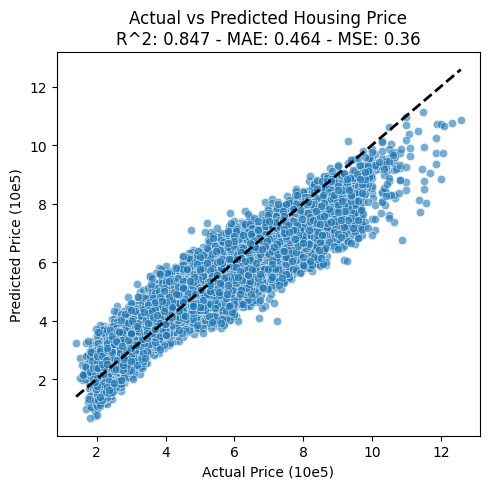

In [215]:
# Save results
results = f'R^2: {r2} - MAE: {mae} - MSE: {mse}'

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("Actual Price (10e5)")
plt.ylabel("Predicted Price (10e5)")
plt.title(f"Actual vs Predicted Housing Price\n{results}")
plt.tight_layout()
plt.savefig('results/actual_vs_predict.png')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

Best Params: {'regressor__fit_intercept': True, 'regressor__positive': False}
Intercept: 5.486135281274829


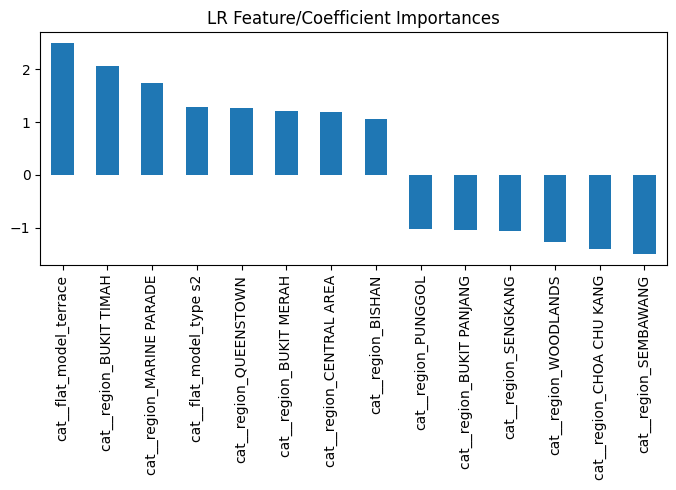

In [232]:
# Feature importance
best_model = regressor.best_estimator_  # pipeline object
linear = best_model.named_steps['regressor']  # access the LinearRegression step

coefs = linear.coef_
intercept = linear.intercept_

print("Best Params:", regressor.best_params_)
print("Intercept:", intercept)

# Get feature names via fitting the preprocessor
preprocessor.fit(X_train)
transformed_columns = preprocessor.get_feature_names_out()

feat_imp = pd.Series(coefs, index=transformed_columns).sort_values(ascending=False)

threshold = 1
feat_imp = feat_imp[feat_imp.abs() > threshold]
feat_imp.plot(kind='bar', figsize=(7, 5))
plt.title("LR Feature/Coefficient Importances")
plt.tight_layout()
plt.savefig('results/lr_feature_importance.png')
plt.show()